In [45]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

In [46]:
def ar_p_simulator_with_deltas(n, m, phi, drift, sigma):

    AR_prices = []
    AR_deltas = []
    
    # Construct the AR and MA coefficient vectors
    ar = np.array([1] + [-coeff for coeff in phi])  # AR coefficients with 1 at the beginning
    ma = np.array([1])  # MA coefficients (no moving average, so this is just [1])
    
    for _ in range(m):

        arma_process = ArmaProcess(ar, ma)
        simulated_values = arma_process.generate_sample(nsample=n)
        # Add drift to the simulated values
        simulated_values += drift * np.arange(n)
        # Scale the simulated values by the noise standard deviation
        AR_price = simulated_values * sigma
        AR_delta = np.diff(AR_price)
        
        AR_prices.append(AR_price)
        AR_deltas.append(AR_delta)
    
    return np.array(AR_prices), np.array(AR_deltas)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    return tokenized_sequences

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

def transfer_weights_from_saved(weights_path, ppo_model, transfer_head, input_dim, hidden_dim, output_dim):
    """
    Load saved supervised weights and transfer to PPO model with optional head transfer
    
    Args:
        weights_path: Path to the saved supervised model weights
        ppo_model: The PPO model to transfer weights to
        transfer_head: If True, also transfer fc layer weights to action_net
        input_dim: Input dimension of the supervised model
        hidden_dim: Hidden dimension of the supervised model
        output_dim: Output dimension of the supervised model
    """
    # Create temporary supervised model to load weights into
    temp_supervised = LSTMModel(input_dim, hidden_dim, output_dim)
    
    # Load the saved weights
    saved_weights = th.load(weights_path, weights_only=False)
    temp_supervised.load_state_dict(saved_weights)
    
    print("Loaded saved supervised weights successfully")
    
    # Transfer LSTM weights
    print("\n=== Transferring LSTM Weights ===")
    supervised_state_dict = temp_supervised.state_dict()
    ppo_lstm_dict = ppo_model.policy.lstm_actor.state_dict()
    
    # Print shapes before transfer for verification
    print("\nWeight shapes before transfer:")
    print("\nSupervised LSTM weights:")
    for key, value in supervised_state_dict.items():
        if 'lstm' in key:
            print(f"{key}: {value.shape}")
    
    print("\nPPO LSTM weights:")
    for key, value in ppo_lstm_dict.items():
        print(f"{key}: {value.shape}")
    
    # Transfer LSTM weights
    lstm_transfer_count = 0
    for ppo_key in ppo_lstm_dict.keys():
        supervised_key = f"lstm.{ppo_key}"
        if supervised_key in supervised_state_dict:
            if ppo_lstm_dict[ppo_key].shape == supervised_state_dict[supervised_key].shape:
                ppo_lstm_dict[ppo_key].copy_(supervised_state_dict[supervised_key])
                lstm_transfer_count += 1
                print(f"Transferred weights for {ppo_key}")
            else:
                print(f"Shape mismatch for {ppo_key}")
    
    # Load the LSTM weights
    ppo_model.policy.lstm_actor.load_state_dict(ppo_lstm_dict)
    print(f"\nSuccessfully transferred {lstm_transfer_count} LSTM weight tensors")
    
    # Transfer head weights if requested
    if transfer_head:
        print("\n=== Transferring Head Weights ===")
        # Get supervised fc weights and biases
        fc_weight = supervised_state_dict['fc.weight']
        fc_bias = supervised_state_dict['fc.bias']
        
        # Get PPO action_net weights and biases
        action_net_state_dict = ppo_model.policy.action_net.state_dict()
        
        print("\nHead weight shapes:")
        print(f"Supervised fc weight: {fc_weight.shape}")
        print(f"Supervised fc bias: {fc_bias.shape}")
        print(f"PPO action_net weight: {action_net_state_dict['weight'].shape}")
        print(f"PPO action_net bias: {action_net_state_dict['bias'].shape}")
        
        # Verify shapes match before transfer
        if (fc_weight.shape == action_net_state_dict['weight'].shape and 
            fc_bias.shape == action_net_state_dict['bias'].shape):
            # Transfer weights
            action_net_state_dict['weight'].copy_(fc_weight)
            action_net_state_dict['bias'].copy_(fc_bias)
            ppo_model.policy.action_net.load_state_dict(action_net_state_dict)
            print("Successfully transferred head weights")
        else:
            print("Shape mismatch in head weights - transfer aborted")
    
    return ppo_model


In [47]:
def plot_price_hist(price, deltas, bin_start, bin_stop, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: AR Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: AR Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()

def supervised_wasserstein(real_data, supervised_data):
    n_timesteps = real_data.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_data[:, t], supervised_data[:, t])
        wasserstein_supervised.append(w_dist)

    # Create visualization
    fig = plt.figure(figsize=(12, 4))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 2)
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.legend()

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_data[:, worst_timestep_supervised]
    generated_data = supervised_data[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()


def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_sequence_metrics(ep_rew, wasserstein, kl_div):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(wasserstein, color='blue')
    axs[1].set_title('Wasserstein Distance')
    axs[1].set_ylabel('WS Distance')
    axs[1].set_xlabel('Model Update')

    axs[2].plot(kl_div, color='blue')
    axs[2].set_title('KL Div. real vs. sim sequences')
    axs[2].set_ylabel('KL Divergence')
    axs[2].set_xlabel('Model Update')

    plt.show()

def plot_discriminator(disc_loss, disc_acc, disc_acc_diff):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(disc_loss, color='blue')
    axs[0].set_title('Discriminator Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc, color='lightblue')
    axs[1].axhline(0.5, color='red', linestyle='--', linewidth=1.5)
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0,1.0)

    axs[2].plot(disc_acc_diff, color='blue')
    axs[2].set_title('Accuracy difference: First vs. Second half of Sequence')
    axs[2].set_ylabel('Accuracy Difference')
    axs[2].set_xlabel('Episode')
    
    plt.show()


def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    # Plot 1: Mean Distribution
    axs[0].hist(supervised_means, bins=bin_edges_mean, alpha=0.8, label='Supervised', color='red')
    axs[0].hist(gail_means, bins=bin_edges_mean, alpha=0.8, label='GAIL', color='green')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # Plot 1: Variance Distribution
    axs[1].hist(supervised_variances, bins=bin_edges_var, alpha=0.8, label='Supervised', color='red')
    axs[1].hist(gail_variances, bins=bin_edges_var, alpha=0.8, label='GAIL', color='green')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(supervised_skew, bins=bin_edges_skew, alpha=0.8, label='Supervised', color='red')
    axs[2].hist(gail_skew, bins=bin_edges_skew, alpha=0.8, label='GAIL', color='green')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def plot_sequences(real_seq, supervised, gail):
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i][1:], label='Real Trajectory', color='skyblue')
        axes[i].plot(supervised[i], label='Supervised', color='red')
        axes[i].plot(gail[i], label='GAIL', color='green')
        axes[i].legend(loc='best')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0, 80)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def wasserstein_dist(real_sequences, supervised, gail):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], gail[:, t])
        wasserstein_gail.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 3)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.plot(wasserstein_gail, label = 'GAIL')
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_supervised]
    generated_data = supervised[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

    # Plot 3: Compare specific timesteps
    ax3 = fig.add_subplot(gs[0, 2])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_gail = np.argmax(wasserstein_gail)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_gail]
    generated_data = gail[:, worst_timestep_gail]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax3.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax3.plot(x_eval, kde_generated(x_eval), label='GAIL', color='green')
    ax3.set_title(f'Distribution Comparison at Timestep {worst_timestep_gail}\n'
                f'(Largest Wasserstein Distance)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_acf(trajectories, nlags):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

def calculate_pacf(trajectories, nlags):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

def plot_acf_pacf(real_sequences, supervised, gail):

    nlags_acf = len(real_sequences[0])-1
    nlags_pacf = int(len(real_sequences[0])/2-2)
    
    # ACFs for real and simulated trajectories
    real_acfs = calculate_acf([real_sequences[i] for i in range(len(real_sequences))], nlags=nlags_acf)
    avg_real_acf = np.mean(real_acfs, axis=0)
    
    supervised_acfs = calculate_acf([supervised[i] for i in range(len(supervised))], nlags=nlags_acf)
    avg_supervised_acf = np.mean(supervised_acfs, axis=0)

    gail_acfs = calculate_acf([gail[i] for i in range(len(gail))], nlags=nlags_acf)
    avg_gail_acf = np.mean(gail_acfs, axis=0)

    # Calculate PACFs for real and simulated trajectories
    real_pacfs = calculate_pacf([real_sequences[i][1:] for i in range(len(real_sequences))], nlags=nlags_pacf)
    avg_real_pacf = np.mean(real_pacfs, axis=0)
    
    supervised_pacfs = calculate_pacf([supervised[i] for i in range(len(supervised))], nlags=nlags_pacf)
    avg_supervised_pacf = np.mean(supervised_pacfs, axis=0)

    gail_pacfs = calculate_pacf([gail[i] for i in range(len(gail))], nlags=nlags_pacf)
    avg_gail_pacf = np.mean(gail_pacfs, axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the averaged ACFs
    axs[0].plot(avg_real_acf, label='Real', color='blue')
    axs[0].plot(avg_supervised_acf, label='Supervised', color='red')
    axs[0].plot(avg_gail_acf, label='GAIL', color='green')
    axs[0].set_title('Average Autocorrelation Function')
    axs[0].set_xlabel('Lag')
    axs[0].set_ylabel('Autocorrelation')
    #axs[0].set_xticks(np.arange(0, nlags_acf, 1))
    axs[0].legend()

    # Plot the averaged PACFs
    axs[1].plot(avg_real_pacf, label='Real', color='blue')
    axs[1].plot(avg_supervised_pacf, label='Supervised', color='red')
    axs[1].plot(avg_gail_pacf, label='GAIL', color='green')
    axs[1].set_title('Average Partial Autocorrelation Function')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Partial Autocorrelation')
    #axs[1].set_xticks(np.arange(0, nlags_pacf, 1))
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def distribution_evolution(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histogram for each timestep
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    # Define common range for all histograms
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max for color scaling
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create visualization
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()

def distribution_evolution_strong_contrast(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histograms (same as before)
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create custom normalization to enhance color contrast
    # Option 1: Using power-law normalization
    from matplotlib.colors import PowerNorm
    norm = PowerNorm(gamma=0.5)  # gamma < 1 will enhance lower values
    
    # Option 2: Alternative - use LogNorm for even more contrast
    # from matplotlib.colors import LogNorm
    # norm = LogNorm(vmin=max(vmin, 0.001), vmax=vmax)  # avoid log(0)
    
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()


$X_t = \mu + 0.6X_{t-1} + 0.4X_{t-2} + 0.3X_{t-3} + 0.1 + \epsilon_t, \quad \epsilon_t \sim N(0, 1)$

**SETTINGS**

In [48]:
phi = [0.6, 0.35, 0.3]       # AR coefficients for positive skew    
drift = 0.1                 # Drift term (constant increment per step)
sigma = 0.5                   # Standard deviation of noise

n_days = 52                 # Length of each sequence
n_sequences = 50000         # Number of Sequences for training

In [49]:
Price_AR, Delta_AR = ar_p_simulator_with_deltas(n = n_days, m = n_sequences, phi=phi, drift=drift, sigma=sigma)
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_AR)),3))

Standard Deviation of Price Deltas: 16.819


In [50]:
bin_width = 0.8
bin_start=-50
bin_stop=50
token_size = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins

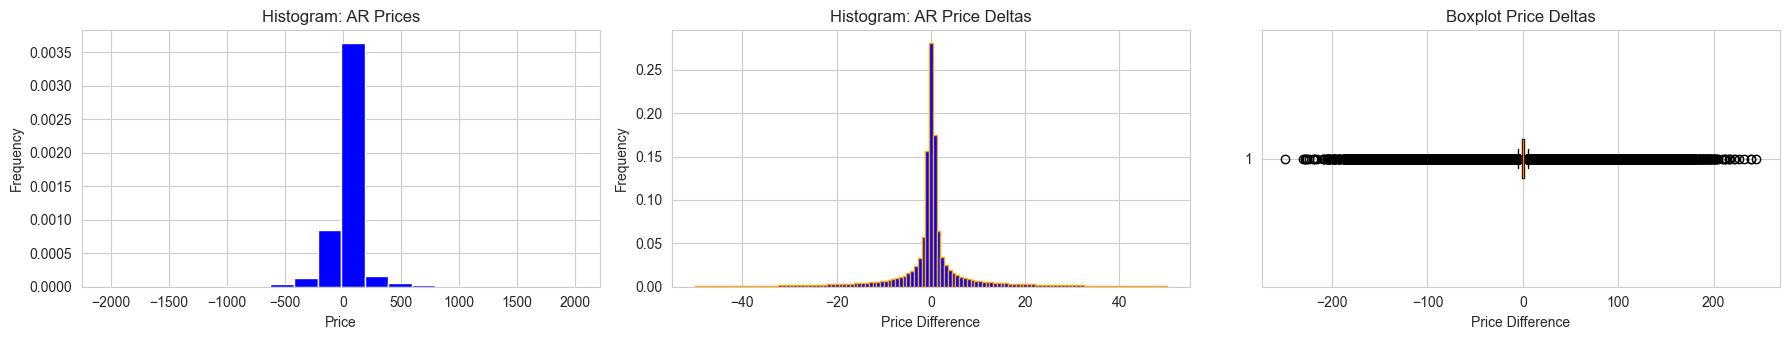

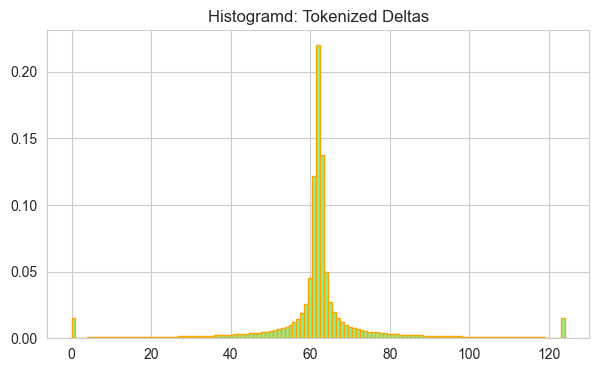

Number of Tokens: 125
Data Shape: (50000, 51)


In [ ]:
plot_price_hist(Price_AR, Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

plt.figure(figsize=(7,4))
plt.hist(np.concatenate(tokenize_deltas(Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)), bins=token_size, density=True, color='lightgreen', edgecolor='orange')
plt.title('Histogram: Tokenized Deltas')
plt.show()

print('Number of Tokens:', token_size)
print('Data Shape:', Delta_AR.shape)

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Changed default input_dim
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # x shape now: [batch_size, sequence_length, vocab_size]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (h_n, c_n)

def to_onehot(tokens, vocab_size):
    """Convert batch of tokens to one-hot vectors"""
    # tokens shape: [batch_size, sequence_length]
    batch_size, seq_length = tokens.shape
    onehot = th.zeros(batch_size, seq_length, vocab_size)
    for i in range(batch_size):
        for j in range(seq_length):
            onehot[i, j, tokens[i, j]] = 1
    return onehot

**SETTINGS**

In [ ]:
# Rest of your parameters remain the same
hidden_dim = 256
batch_size = 512
learning_rate = 5e-4
seq_len = n_days-1
num_epochs = 50

In [54]:
# Create model with new input dimension
model_supervised = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
best_loss = float('inf')
max_grad_norm = 1.0

for epoch in range(num_epochs):
    model_supervised.train()
    temp_loss = []

    # Generate fresh data (this stays the same)
    _, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
    train_data = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

    for batch_idx in range(0, len(train_data), batch_size):
        batch = train_data[batch_idx:batch_idx + batch_size]
        
        # Main changes here: convert inputs to one-hot
        input_tokens = th.tensor(batch[:, :-1], dtype=th.long)  # Changed to long type
        inputs = to_onehot(input_tokens, token_size)  # Convert to one-hot
        targets = th.tensor(batch[:, 1:], dtype=th.long)
        
        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))
        targets = targets.view(-1)
        
        loss = criterion_supervised(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        
        optimizer.step()
        
        temp_loss.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            th.save(model_supervised.state_dict(), 'supervised_weights_len_50.pth')
    
    train_loss.extend(temp_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_loss):.4f}")

Epoch 1/75 - Train Loss: 3.0763
Epoch 2/75 - Train Loss: 1.9533
Epoch 3/75 - Train Loss: 1.5428
Epoch 4/75 - Train Loss: 1.2711
Epoch 5/75 - Train Loss: 1.2224
Epoch 6/75 - Train Loss: 1.1863
Epoch 7/75 - Train Loss: 1.1737
Epoch 8/75 - Train Loss: 1.1523
Epoch 9/75 - Train Loss: 1.1332
Epoch 10/75 - Train Loss: 1.1241
Epoch 11/75 - Train Loss: 1.1213
Epoch 12/75 - Train Loss: 1.1107
Epoch 13/75 - Train Loss: 1.1075
Epoch 14/75 - Train Loss: 1.1049
Epoch 15/75 - Train Loss: 1.1025
Epoch 16/75 - Train Loss: 1.1062
Epoch 17/75 - Train Loss: 1.0980
Epoch 18/75 - Train Loss: 1.0964
Epoch 19/75 - Train Loss: 1.0962
Epoch 20/75 - Train Loss: 1.0945
Epoch 21/75 - Train Loss: 1.0946
Epoch 22/75 - Train Loss: 1.0937
Epoch 23/75 - Train Loss: 1.0929
Epoch 24/75 - Train Loss: 1.0917
Epoch 25/75 - Train Loss: 1.0990
Epoch 26/75 - Train Loss: 1.0905
Epoch 27/75 - Train Loss: 1.0907
Epoch 28/75 - Train Loss: 1.0890
Epoch 29/75 - Train Loss: 1.0888
Epoch 30/75 - Train Loss: 1.0894
Epoch 31/75 - Train

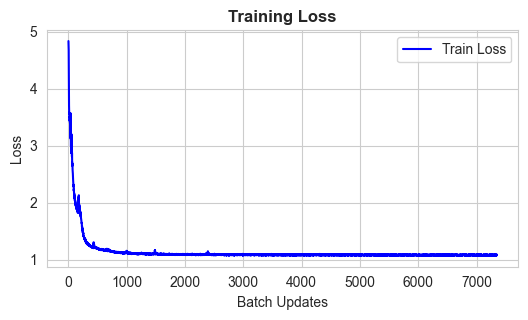

In [55]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Train Loss', color='blue', linewidth=1.5)
plt.title('Training Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

### Supervised Inference

In [56]:
_, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
test_data = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

# Update model creation to match new architecture
inference_model = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('supervised_weights_len_50.pth', weights_only=False))
criterion_inference = nn.CrossEntropyLoss()

test_data_inference = th.tensor(test_data, dtype=th.long)  # Changed to long type

test_losses = []
supervised_data = []

inference_model.eval()

def to_onehot_single(token, vocab_size):
    """Convert single token to one-hot vector"""
    onehot = th.zeros(vocab_size)
    onehot[token.long()] = 1
    return onehot

with th.no_grad():
    for sequence in test_data_inference:
        token_loss = 0
        
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]
        
        hidden = None
        
        for i in range(1, len(sequence)):
            # Convert last token to one-hot
            last_token = sim_trajectory[-1]
            input_onehot = to_onehot_single(last_token, token_size).reshape(1, 1, -1)
            
            logits, hidden = inference_model(input_onehot, hidden)
            
            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())
            
            # Loss calculation
            true_token = sequence[i].unsqueeze(-1)
            loss = criterion_inference(logits.squeeze(1), true_token.long())
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        supervised_data.append(sim_trajectory[1:])

supervised_data = np.array(supervised_data)

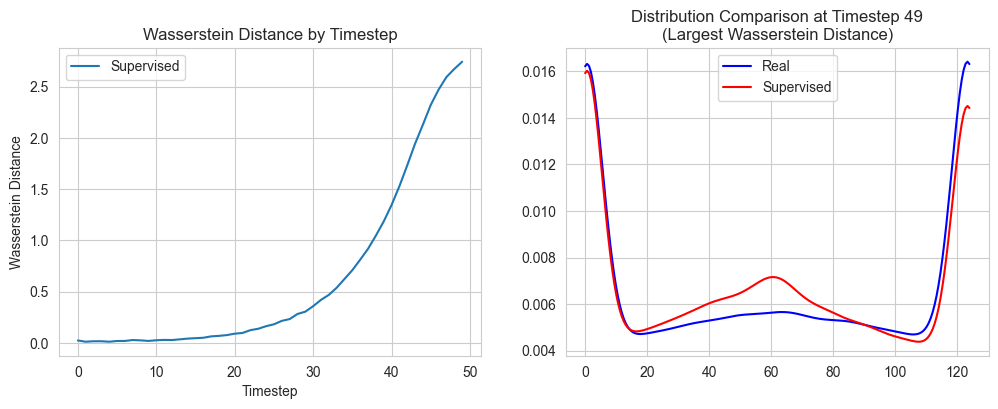

In [57]:
supervised_wasserstein(test_data[:,1:], supervised_data)

### GAIL

In [58]:
class LSTM_Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits, hidden

In [59]:
class CustomEnv(gym.Env):
    
    def __init__(self, 
                 sequence_length, token_size, bin_start, bin_stop, bin_width,
                 phi, drift, sigma,
                 discriminator, d_optimizer):
        
        super(CustomEnv, self).__init__()

        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        # Token Settings
        self.sequence_length = sequence_length
        self.num_bins = int((bin_stop - bin_start) / bin_width)
        self.bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

        # AR Settings
        self.phi = phi
        self.drift = drift
        self.sigma = sigma
        self.ar = np.array([1] + [-coeff for coeff in self.phi])  # AR coefficients with 1 at the beginning
        self.ma = np.array([1])  # MA coefficients (no moving average, so this is just [1])
        
        # Discriminator
        self.discriminator = discriminator
        self.d_optimizer = d_optimizer
        self.criterion = nn.BCEWithLogitsLoss()

        # Reset
        self.seq_len = None
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
    
    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_seq.append(action)

        ###=====REWARD=====###
        reward = self._get_reward(action)
        ###=====REWARD=====###
        
        done = self._is_done()
        
        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def reset(self, *, seed = None, options = None):

        real_seq = self.get_AR_sequence()
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
        
        start_token = int(real_seq[0])

        return start_token, {}

    def _get_reward(self, action):

        self.discriminator.eval()

        with th.no_grad():
            temp_action = th.tensor(np.array([[action]]), dtype=th.long)
            prediction, self.hidden_states = self.discriminator(temp_action, self.hidden_states)
            prediction = prediction[0,0]
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            reward = -(seq_loss.item())
            return reward

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def get_AR_sequence(self):
        
        arma_process = ArmaProcess(self.ar, self.ma)
        
        simulated_values = arma_process.generate_sample(nsample=self.sequence_length)
        simulated_values += drift * np.arange(self.sequence_length)
        
        AR_price = simulated_values * sigma
        AR_delta = np.diff(AR_price)
        
        tokenized_data = np.digitize(AR_delta, bins=self.bin_edges, right=False) - 1
        
        final_seq = np.clip(tokenized_data, 0, self.num_bins - 1)
        
        return final_seq

    def discriminator_accuracy(self, real_data, fake_data):
        
        self.discriminator.eval()
        
        with th.no_grad():
            batch_real = th.tensor(real_data, dtype=th.long)
            batch_fake = th.tensor(fake_data, dtype=th.long)
            
            seq_len = batch_real.size(1)
            split_idx = seq_len // 2
            
            # Full sequence predictions
            real_preds, _ = self.discriminator(batch_real, None)
            fake_preds, _ = self.discriminator(batch_fake, None)
            
            real_probs = th.sigmoid(real_preds)
            fake_probs = th.sigmoid(fake_preds)
            
            # Full accuracy
            correct_real = (real_probs > 0.5).float().sum()
            correct_fake = (fake_probs < 0.5).float().sum()
            total = real_probs.numel() + fake_probs.numel()
            acc_full = (correct_real + correct_fake) / total
            
            # First half accuracy
            correct_real_first = (real_probs[:split_idx] > 0.5).float().sum()
            correct_fake_first = (fake_probs[:split_idx] < 0.5).float().sum()
            total_first = real_probs[:split_idx].numel() + fake_probs[:split_idx].numel()
            acc_1 = (correct_real_first + correct_fake_first) / total_first
            
            # Second half accuracy
            correct_real_second = (real_probs[split_idx:] > 0.5).float().sum()
            correct_fake_second = (fake_probs[split_idx:] < 0.5).float().sum()
            total_second = real_probs[split_idx:].numel() + fake_probs[split_idx:].numel()
            acc_2 = (correct_real_second + correct_fake_second) / total_second
            
            return acc_full.item(), acc_1.item(), acc_2.item(), (acc_2 - acc_1).item()
    
    def train_discriminator(self, batch_real, batch_fake):
        
        self.discriminator.train()
        
        batch_real = th.tensor(batch_real, dtype=th.long)
        batch_fake = th.tensor(batch_fake, dtype=th.long)

        # Forward pass - real data
        real_preds, _ = self.discriminator(batch_real, None)
        real_preds = real_preds.view(-1)
        real_labels = th.ones_like(real_preds) * 0.9  # Label smoothing
        real_loss = self.criterion(real_preds, real_labels)

        # Forward pass - fake data
        fake_preds, _ = self.discriminator(batch_fake, None)
        fake_preds = fake_preds.view(-1)
        fake_labels = th.ones_like(fake_preds) * 0.1  # Label smoothing
        fake_loss = self.criterion(fake_preds, fake_labels)

        # Combined loss and update
        d_loss = (real_loss + fake_loss) / 2
        self.d_optimizer.zero_grad()
        d_loss.backward()
        th.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=0.5)  # Add gradient clipping
        self.d_optimizer.step()

        with th.no_grad():
            discriminator_loss = d_loss.item()
        
        return discriminator_loss


In [63]:
class CustomCallback(BaseCallback):

    def __init__(self, verbose, display_rollout, disc_batch_size):
        
        super(CustomCallback, self).__init__(verbose)
        
        # Display Rollout
        self.display_rollout = display_rollout
        # Losses
        self.pg_losses, self.value_losses, self.entropy_losses = [], [], []
        # Rewards
        self.rewards = []
        
        self.batch_size = disc_batch_size

        # KL and Wasserstein
        self.sequence_metrics = {
            'kl_div': [],
            'wasserstein': []
        }

        # Metrics after every network update of the discriminator
        self.disc_metrics_per_batch = {
            'loss': [], 
            'accuracy': [],
            'accuracy_1': [],
            'accuracy_2': [],
            'accuracy_difference': [],
            'n_batches': []
        }

        # Save best model
        self.best_wasserstein = float('inf')  # Initialize with infinity
        self.best_model_path = "best_GAIL_len_50"   # Path to save best model

    def _on_training_start(self) -> None:
        pass

    def _on_rollout_start(self) -> None:
        
        self.save_losses()

        real_data, fake_data = self.get_sequences(n = 10000)

        wasser_dist = self.calculate_wasserstein_distance(real_data, fake_data)
        kl_div = self.calculate_kl_divergence(real_data, fake_data)

        self.sequence_metrics['wasserstein'].append(wasser_dist)
        self.sequence_metrics['kl_div'].append(kl_div)

        # Save model if we have a new best Wasserstein distance
        if wasser_dist < self.best_wasserstein:
            self.best_wasserstein = wasser_dist
            print(f"\nNew best Wasserstein distance: {wasser_dist:.3f}, saving model...")
            self.model.save(f"{self.best_model_path}")

        for env in self.training_env.envs:

            pre_acc, _, _, pre_diff = env.unwrapped.discriminator_accuracy(real_data, fake_data)

            metrics = {
                'losses': [], 
                'accuracies': [],
                'pre_acc': 0,
                'post_acc': 0
                }

            max_accuracy = 0.75     # Don't want discriminator too strong
            min_batches = 10        # Minimum batches to train on
            max_batches = 100       # Minimum batches to train on

            # Dynamic batch sizing
            curr_batch_size = batch_size
            if pre_acc < 0.55:  # If discriminator is very weak
                curr_batch_size = batch_size * 2  # Train on more data
            
            for batch in range(max_batches):
                
                real_batch, fake_batch = self.get_sequences(n=curr_batch_size)
                batch_loss = env.unwrapped.train_discriminator(real_batch, fake_batch)
                curr_acc, curr_acc_1, curr_acc_2, curr_acc_diff = env.unwrapped.discriminator_accuracy(real_batch, fake_batch)

                metrics['losses'].append(batch_loss)
                metrics['accuracies'].append(curr_acc)
                
                self.disc_metrics_per_batch['loss'].append(batch_loss)
                self.disc_metrics_per_batch['accuracy'].append(curr_acc)
                self.disc_metrics_per_batch['accuracy_1'].append(curr_acc_1)
                self.disc_metrics_per_batch['accuracy_2'].append(curr_acc_2)
                self.disc_metrics_per_batch['accuracy_difference'].append(curr_acc_diff)

                if batch >= min_batches:

                    if curr_acc > max_accuracy:
                        print(f"Discriminator too strong ({curr_acc:.3f}), stopping")
                        break

                    recent_acc = np.mean(metrics['accuracies'][-3:])  # Last 3 batches
                    if 0.60 < recent_acc < 0.75 and np.std(metrics['accuracies'][-3:]) < 0.02:
                        print(f"Discriminator stable at {recent_acc:.3f}, stopping")
                        break

                    # Stop if no improvement in last 5 batches
                    if batch > 10 and np.std(metrics['accuracies'][-10:]) < 0.01:
                        print("Discriminator converged, stopping")
                        break
                
                # Adjust batch size if needed
                if batch % 10 == 0:  # Every 5 batches
                    if curr_acc < 0.60:  # Still too weak
                        curr_batch_size = min(curr_batch_size * 2, 256)  # Increase data
                    elif curr_acc > 0.80:  # Getting too strong
                        curr_batch_size = max(curr_batch_size // 2, n_sequences)  # Decrease data
                
            self.disc_metrics_per_batch['n_batches'].append(batch + 1)
            
            post_acc, _, _, post_diff = env.unwrapped.discriminator_accuracy(real_data, fake_data)

            print(f"Wasserstein: {wasser_dist:.3f} - KL Div: {kl_div:.3f} - Stopped after {batch + 1} batches")
            print(f"Pre Accuracy: {pre_acc:.3f} - Post Accuracy: {post_acc:.3f} - Pre Acc Diff: {pre_diff:.3f} - Post Acc Diff: {post_diff:.3f}")
    
    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:

        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()
    
    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def save_reward(self):
        # Get rewards without reshaping
        rewards = self.model.rollout_buffer.rewards  # Shape: (n_steps, n_envs)
        episode_starts = self.model.rollout_buffer.episode_starts
        
        all_sequence_rewards = []
        
        # Process each environment separately
        for env_idx in range(self.training_env.num_envs):
            # Get rewards and episode starts for this environment
            env_rewards = rewards[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            if not env_starts[0]:
                ep_start_idx = np.r_[0, ep_start_idx]
                
            # Calculate rewards for this env's sequences
            sequence_rewards = np.add.reduceat(env_rewards, np.r_[0, ep_start_idx[1:]])
            all_sequence_rewards.extend(sequence_rewards)
        
        # Store average across all envs
        self.rewards.append(np.mean(all_sequence_rewards))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Get original shaped arrays
        observations = self.model.rollout_buffer.observations  # Shape: (n_steps, n_envs)
        actions = self.model.rollout_buffer.actions
        rewards = self.model.rollout_buffer.rewards
        returns = self.model.rollout_buffer.returns
        episode_starts = self.model.rollout_buffer.episode_starts
        values = self.model.rollout_buffer.values
        log_probs = self.model.rollout_buffer.log_probs
        advantages = self.model.rollout_buffer.advantages
        
        # Print header with line
        header = "  env_id    step    observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))
        print(header)
        print("-" * (len(header) + 5))
        
        # For each environment
        for env_idx in range(self.training_env.num_envs):
            # Get data for this environment
            env_obs = observations[:, env_idx]
            env_actions = actions[:, env_idx]
            env_rewards = rewards[:, env_idx]
            env_returns = returns[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            env_values = values[:, env_idx]
            env_log_probs = log_probs[:, env_idx]
            env_advantages = advantages[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            
            # Print rows for this environment
            last_idx = -1
            for step in range(len(env_obs)):
                if step in ep_start_idx:
                    if last_idx != -1:
                        print("=" * (len(header) + 5))
                    print(f"Environment {env_idx} - New Episode")
                    print("-" * (len(header) + 5))
                
                # Convert arrays to strings or get first element if array
                obs_str = str(env_obs[step].item()) if hasattr(env_obs[step], 'item') else str(env_obs[step])
                action_str = str(env_actions[step].item()) if hasattr(env_actions[step], 'item') else str(env_actions[step])
                
                print(
                    f"Obs: {obs_str:8s}  "
                    f"Act: {action_str:4s}  "
                    f"Rew: {env_rewards[step]:6.2f}  "
                    f"Ret: {env_returns[step]:7.2f}  "
                    f"Start: {int(env_starts[step]):1d}  "
                    f"Val: {env_values[step]:6.2f}  "
                    f"LogP: {env_log_probs[step]:8.2f}  "
                    f"Adv: {env_advantages[step]:8.2f}")
                
                last_idx = step
            
            print("=" * (len(header) + 5))
            print(f"End of Environment {env_idx}")
            print("\n")

    def get_sequences(self, n):

        real_data = []
        fake_data = []
        
        # 1. Batch process for each environment
        for env in self.training_env.envs:
            # Get all real sequences at once
            real_seqs = [env.unwrapped.get_AR_sequence() for _ in range(n)]
            
            # Prepare batch for model.predict
            batch_size = n
            actions = np.array([seq[0] for seq in real_seqs])
            lstm_states = None
            episode_starts = np.ones((batch_size,), dtype=bool)
            
            # Initialize all fake sequences
            curr_seqs = [[] for _ in range(batch_size)]
            seq_len = len(real_seqs[0]) - 1
            
            # Generate all sequences in parallel
            for _ in range(seq_len):
                # Predict entire batch at once
                actions, lstm_states = self.model.predict(
                    actions,
                    state=lstm_states,
                    episode_start=episode_starts,
                    deterministic=False
                )
                
                # Update all sequences at once
                for i, action in enumerate(actions):
                    curr_seqs[i].append(action.item())
                
                episode_starts = np.zeros((batch_size,), dtype=bool)
            
            # Append results
            fake_data.extend(curr_seqs)
            real_data.extend([seq[1:] for seq in real_seqs])
        
        return np.array(real_data), np.array(fake_data)
    
    def calculate_wasserstein_distance(self, real_data, fake_data):
        
        wasserstein_distances = []
        for i in range(len(real_data[0])):
            w_dist = wasserstein_distance(real_data[:, i], fake_data[:, i])
            wasserstein_distances.append(w_dist)

        # Different ways to analyze the results
        return np.mean(wasserstein_distances)  # Overall performance
    
    def calculate_kl_divergence(self, real_sequences, fake_sequences, eps=1e-10):

        # Flatten sequences and count tokens
        real_tokens = np.concatenate(real_sequences)
        fake_tokens = np.concatenate(fake_sequences)
        
        # Get unique vocabulary from both distributions
        vocab = set(real_tokens) | set(fake_tokens)
        
        # Calculate token counts and totals
        real_counts = Counter(real_tokens)
        fake_counts = Counter(fake_tokens)
        
        total_real = len(real_tokens)
        total_fake = len(fake_tokens)
        
        # Calculate probabilities with smoothing for all tokens in vocabulary
        real_probs = {token: (real_counts.get(token, 0) + eps) / (total_real + eps * len(vocab))
                    for token in vocab}
        fake_probs = {token: (fake_counts.get(token, 0) + eps) / (total_fake + eps * len(vocab))
                    for token in vocab}
        
        # Calculate KL divergence
        kl_div = sum(p_real * np.log2(p_real / fake_probs[token])
                    for token, p_real in real_probs.items())
        
        return kl_div


In [64]:
discriminator = LSTM_Discriminator(vocab_size=token_size, embedding_dim=32, hidden_dim=256)
d_optimizer = optim.Adam(discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

env_GAIL = CustomEnv(n_days, token_size, bin_start, bin_stop, bin_width,
                     phi, drift, sigma, discriminator, d_optimizer)

env_GAIL = Monitor(env_GAIL, filename=None)

model_pre_weight = RecurrentPPO(

    policy='MlpLstmPolicy',
    env=env_GAIL,
    verbose=0,

    n_steps=300*30,             # Fewer steps per update
    batch_size=30*30,           # Smaller batches
    n_epochs=3,                 # Fewer epochs (less aggressive updates)
    
    clip_range=0.05,            # Lower PPO clipping
    ent_coef=0.001,             # Moderate exploration
    vf_coef=0.1,                # Balanced value function importance
    gamma=0.99,                 # Standard discount
    gae_lambda=0.95,            # Standard GAE lambda

    learning_rate=1e-6,         # Standard starting LR
    
    policy_kwargs=dict(
        lstm_hidden_size=256,
        n_lstm_layers=2,
        net_arch=dict(pi=[], vf=[]),
        shared_lstm=True,  # Use shared LSTM
        enable_critic_lstm=False,  # Disable separate critic LSTM
    )
)

callback_GAIL = CustomCallback(verbose=0, display_rollout=False, disc_batch_size=128)

In [65]:
model_post_weight = transfer_weights_from_saved('supervised_weights_len_50.pth', model_pre_weight, True, token_size, hidden_dim, token_size)

Loaded saved supervised weights successfully

=== Transferring LSTM Weights ===

Weight shapes before transfer:

Supervised LSTM weights:
lstm.weight_ih_l0: torch.Size([1024, 125])
lstm.weight_hh_l0: torch.Size([1024, 256])
lstm.bias_ih_l0: torch.Size([1024])
lstm.bias_hh_l0: torch.Size([1024])
lstm.weight_ih_l1: torch.Size([1024, 256])
lstm.weight_hh_l1: torch.Size([1024, 256])
lstm.bias_ih_l1: torch.Size([1024])
lstm.bias_hh_l1: torch.Size([1024])

PPO LSTM weights:
weight_ih_l0: torch.Size([1024, 125])
weight_hh_l0: torch.Size([1024, 256])
bias_ih_l0: torch.Size([1024])
bias_hh_l0: torch.Size([1024])
weight_ih_l1: torch.Size([1024, 256])
weight_hh_l1: torch.Size([1024, 256])
bias_ih_l1: torch.Size([1024])
bias_hh_l1: torch.Size([1024])
Transferred weights for weight_ih_l0
Transferred weights for weight_hh_l0
Transferred weights for bias_ih_l0
Transferred weights for bias_hh_l0
Transferred weights for weight_ih_l1
Transferred weights for weight_hh_l1
Transferred weights for bias_ih_l

In [66]:
model_post_weight.learn(100000, callback=callback_GAIL)
env_GAIL.close()


New best Wasserstein distance: 0.662, saving model...
Discriminator converged, stopping
Wasserstein: 0.662 - KL Div: 0.003 - Stopped after 12 batches
Pre Accuracy: 0.501 - Post Accuracy: 0.514 - Pre Acc Diff: -0.006 - Post Acc Diff: 0.005

New best Wasserstein distance: 0.458, saving model...
Discriminator converged, stopping
Wasserstein: 0.458 - KL Div: 0.002 - Stopped after 12 batches
Pre Accuracy: 0.511 - Post Accuracy: 0.517 - Pre Acc Diff: -0.042 - Post Acc Diff: -0.042
Discriminator converged, stopping
Wasserstein: 0.627 - KL Div: 0.003 - Stopped after 33 batches
Pre Accuracy: 0.519 - Post Accuracy: 0.530 - Pre Acc Diff: -0.026 - Post Acc Diff: 0.004
Discriminator converged, stopping
Wasserstein: 0.556 - KL Div: 0.003 - Stopped after 17 batches
Pre Accuracy: 0.525 - Post Accuracy: 0.524 - Pre Acc Diff: -0.027 - Post Acc Diff: -0.023
Discriminator converged, stopping
Wasserstein: 0.562 - KL Div: 0.003 - Stopped after 14 batches
Pre Accuracy: 0.522 - Post Accuracy: 0.522 - Pre Acc

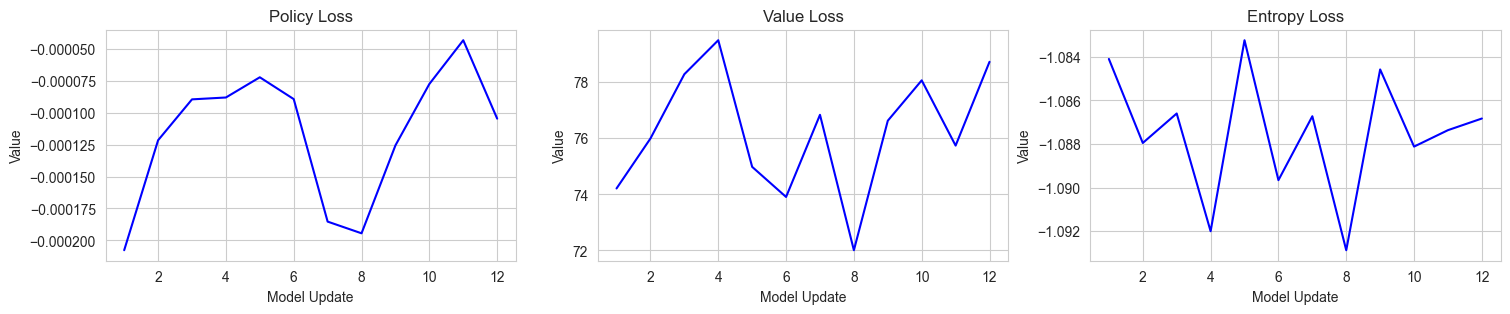

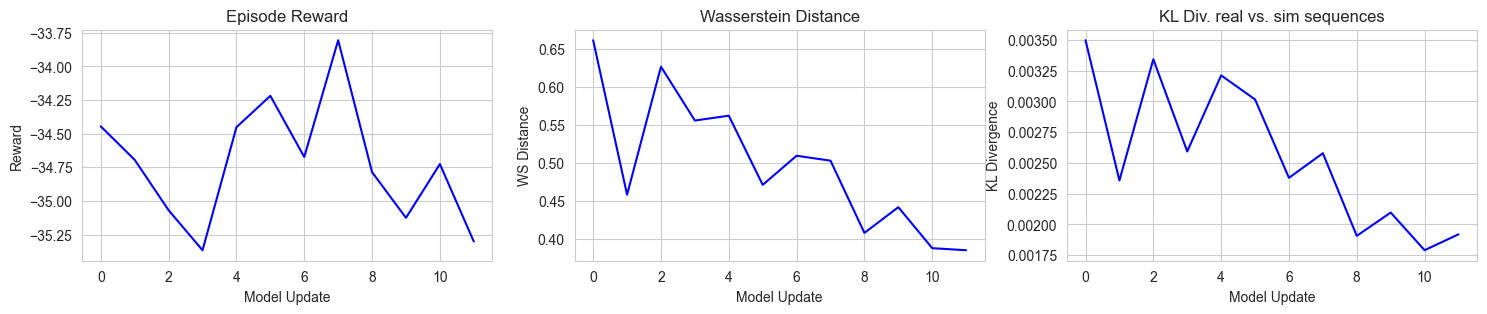

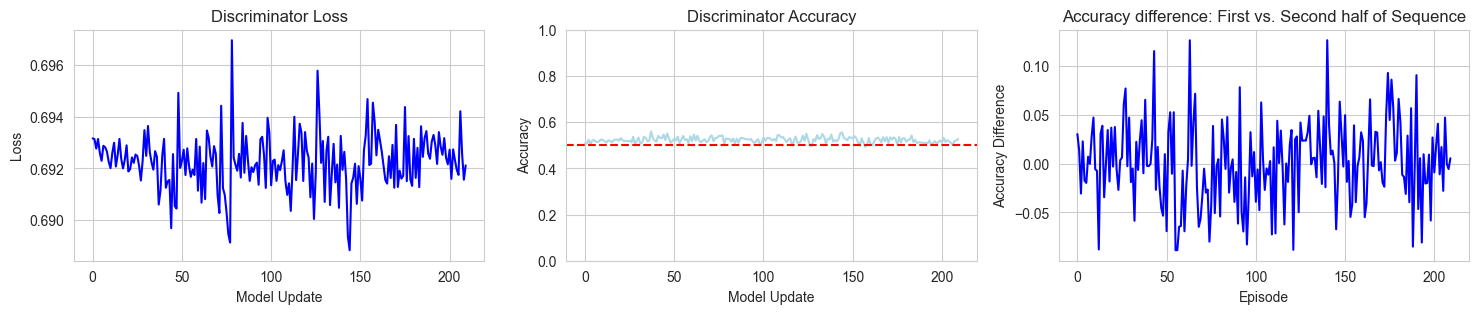

In [67]:
plot_losses(callback_GAIL.pg_losses, callback_GAIL.value_losses, callback_GAIL.entropy_losses)
plot_sequence_metrics(callback_GAIL.rewards, callback_GAIL.sequence_metrics['wasserstein'],
                      callback_GAIL.sequence_metrics['kl_div'])
plot_discriminator(callback_GAIL.disc_metrics_per_batch['loss'],
                   callback_GAIL.disc_metrics_per_batch['accuracy'],
                   callback_GAIL.disc_metrics_per_batch['accuracy_difference'])

In [68]:
best_model = RecurrentPPO.load("best_GAIL_len_50", weights_only=False)

real_data = []
gail_data = []

# Get all real sequences at once
real_seqs = [env_GAIL.unwrapped.get_AR_sequence() for _ in range(n_sequences)]

# Prepare batch for model.predict
batch_size = n_sequences
actions = np.array([seq[0] for seq in real_seqs])
lstm_states = None
episode_starts = np.ones((batch_size,), dtype=bool)

# Initialize all fake sequences
curr_seqs = [[] for _ in range(batch_size)]
seq_len = len(real_seqs[0]) - 1

# Generate all sequences in parallel
for _ in range(seq_len):
    # Predict entire batch at once
    actions, lstm_states = best_model.predict(
        actions,
        state=lstm_states,
        episode_start=episode_starts,
        deterministic=False
    )
    
    # Update all sequences at once
    for i, action in enumerate(actions):
        curr_seqs[i].append(action.item())
    
    episode_starts = np.zeros((batch_size,), dtype=bool)

# Append results
gail_data.extend(curr_seqs)
real_data.extend([seq[1:] for seq in real_seqs])

real_data = np.array(real_data)
gail_data = np.array(gail_data)

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [69]:
real_means, real_variances, real_std_devs, real_skew, real_kurtosis = calculate_statistics(real_data)
supervised_means, supervised_variances, supervised_std_devs, supervised_skew, supervised_kurtosis = calculate_statistics(supervised_data)
gail_means, gail_variances, gail_std_devs, gail_skew, gail_kurtosis = calculate_statistics(gail_data)

bin_start_mean = min(np.min(supervised_means), np.min(real_means))
bin_stop_mean = max(np.max(supervised_means), np.max(real_means))
bin_start_var = min(np.min(supervised_variances), np.min(real_variances))
bin_stop_var = max(np.max(supervised_variances), np.max(real_variances))
bin_start_skew = min(np.min(supervised_skew), np.min(real_skew))
bin_stop_skew = max(np.max(supervised_skew), np.max(real_skew))


In [70]:
bin_width_mean = 1
bin_width_var = 10
bin_width_skew = 0.30

bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

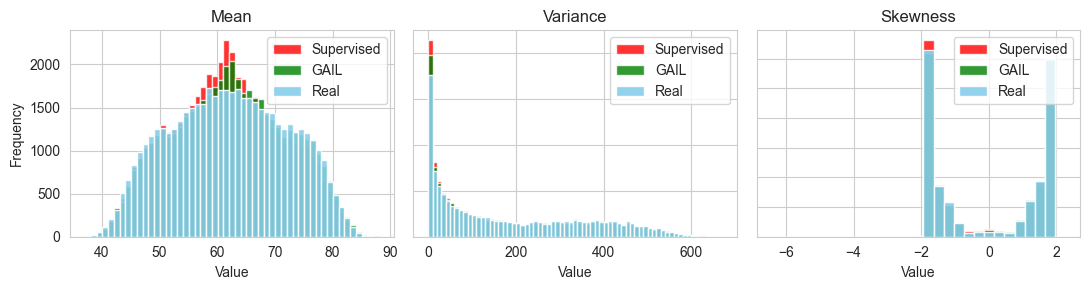

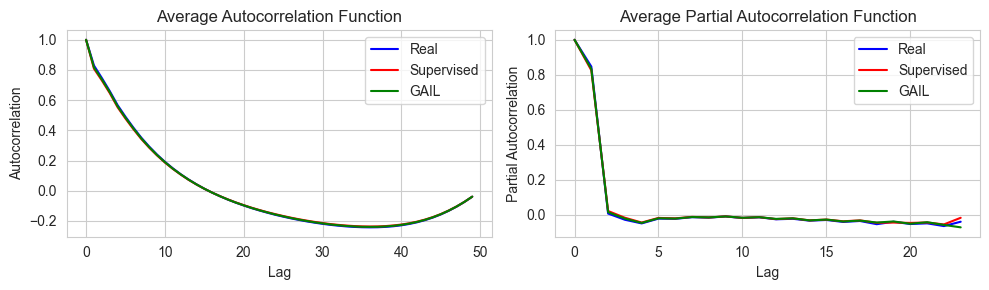

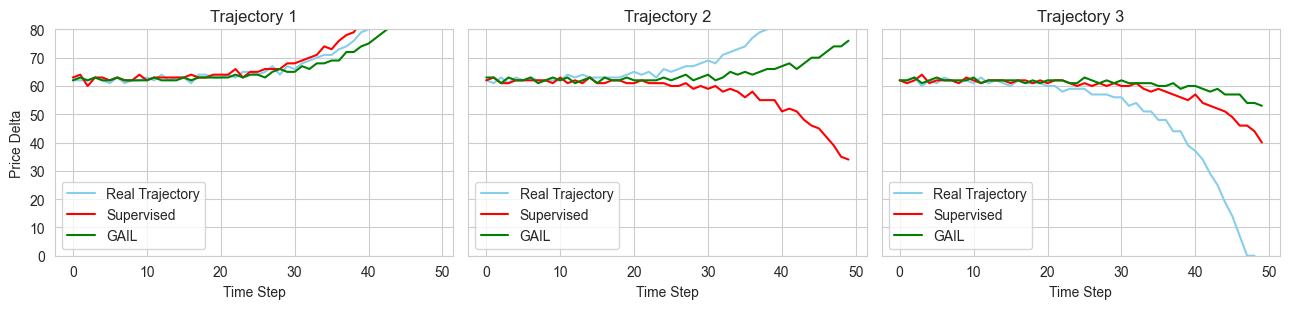

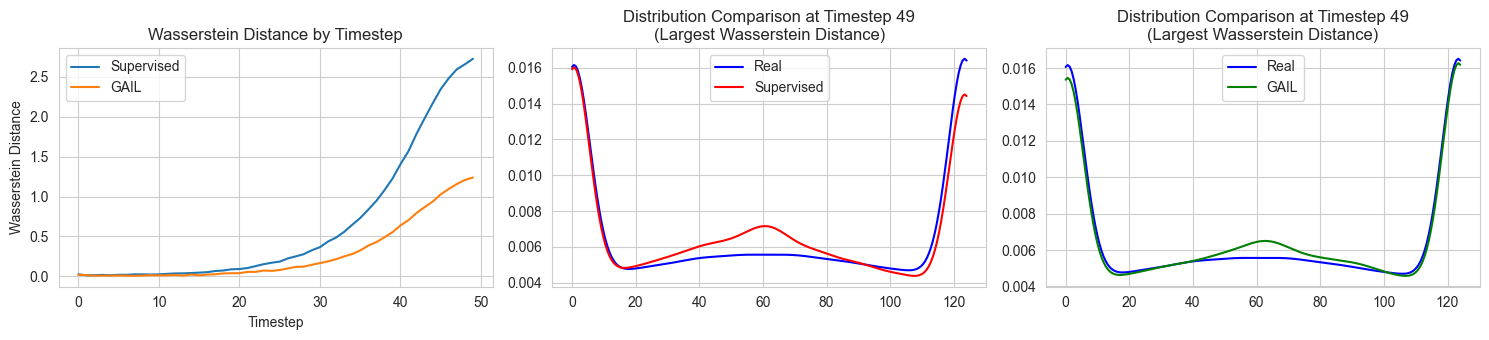

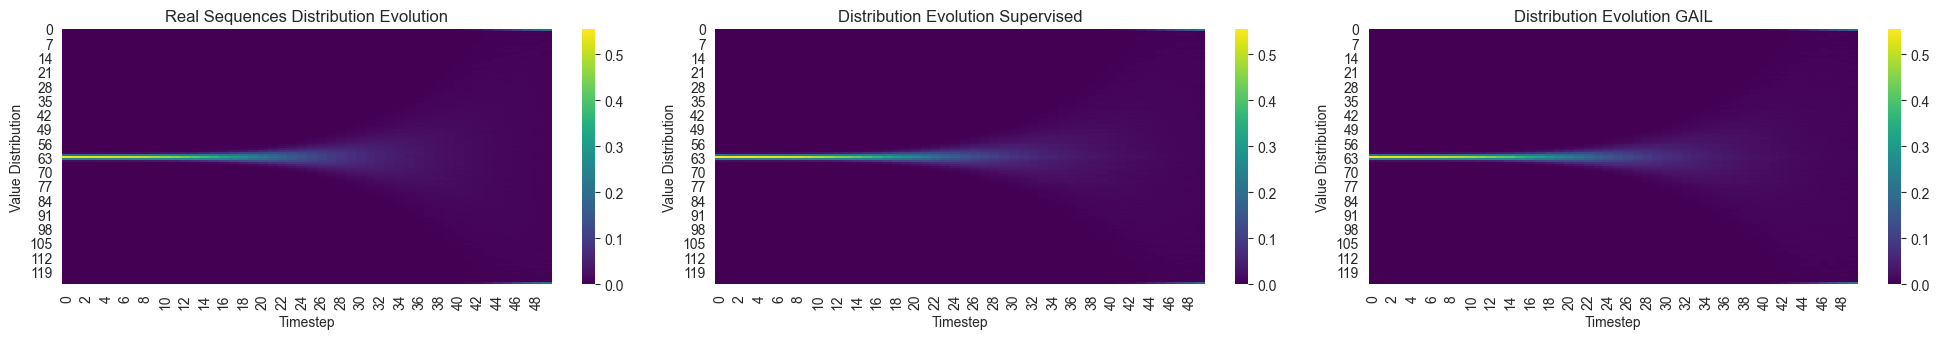

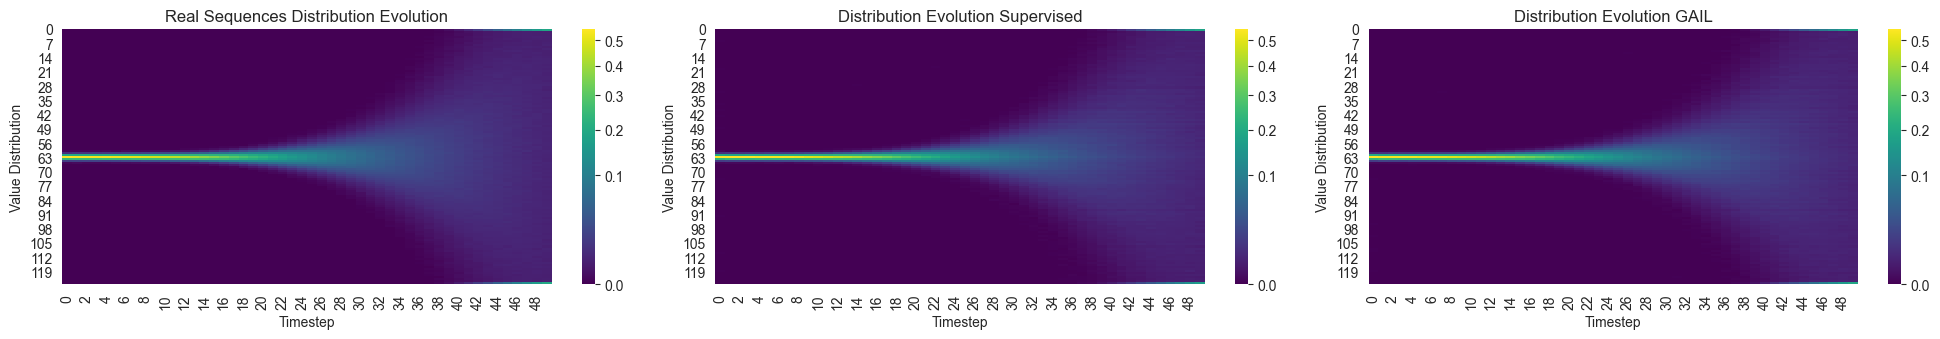

In [71]:
plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew)
plot_acf_pacf(real_data, supervised_data, gail_data)
plot_sequences(real_data, supervised_data, gail_data)
wasserstein_dist(real_data, supervised_data, gail_data)
distribution_evolution(real_data, supervised_data, gail_data, token_size)
distribution_evolution_strong_contrast(real_data, supervised_data, gail_data, token_size)
